# Import the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

df = pd.read_csv('winequality-red.csv')

In [2]:
# Have a look at the first five rows
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

### Exploratory Data Analysis

<AxesSubplot:>

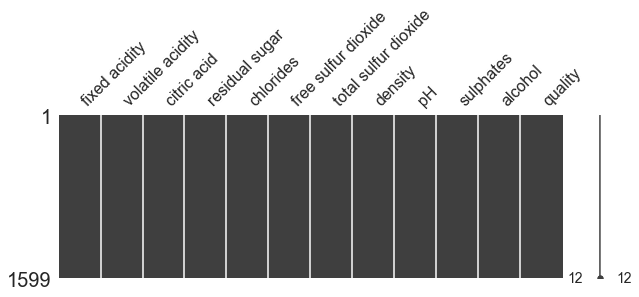

In [4]:
# Check for missing values
import missingno as mi
mi.matrix(df, figsize = (10,3))

In [5]:
def to_cat(df):
    '''For columns that have few number of unique values (< 0.05), convert to category to save memory'''
    cols = df.columns
    for col in cols:
        ratio = df[col].nunique() / len(df)
        if ratio < 0.05:
            df[col] = df[col].astype('category')
    return df

df = (df.pipe(to_cat))

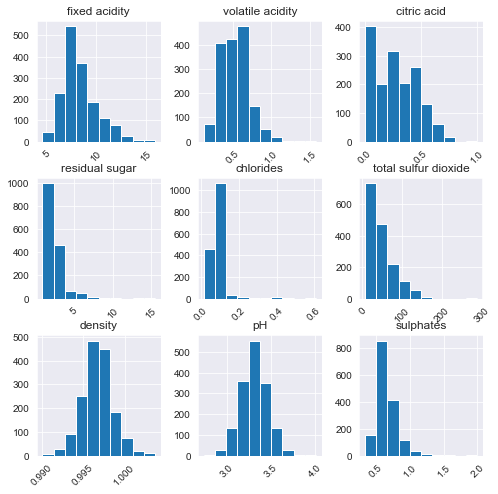

In [6]:
# Plot distributions of numeric features
df.hist(figsize=(8,8), xrot=45)
plt.show()

As all features except for targeted one are skewedly or normally distributed, we can apply normalization to all

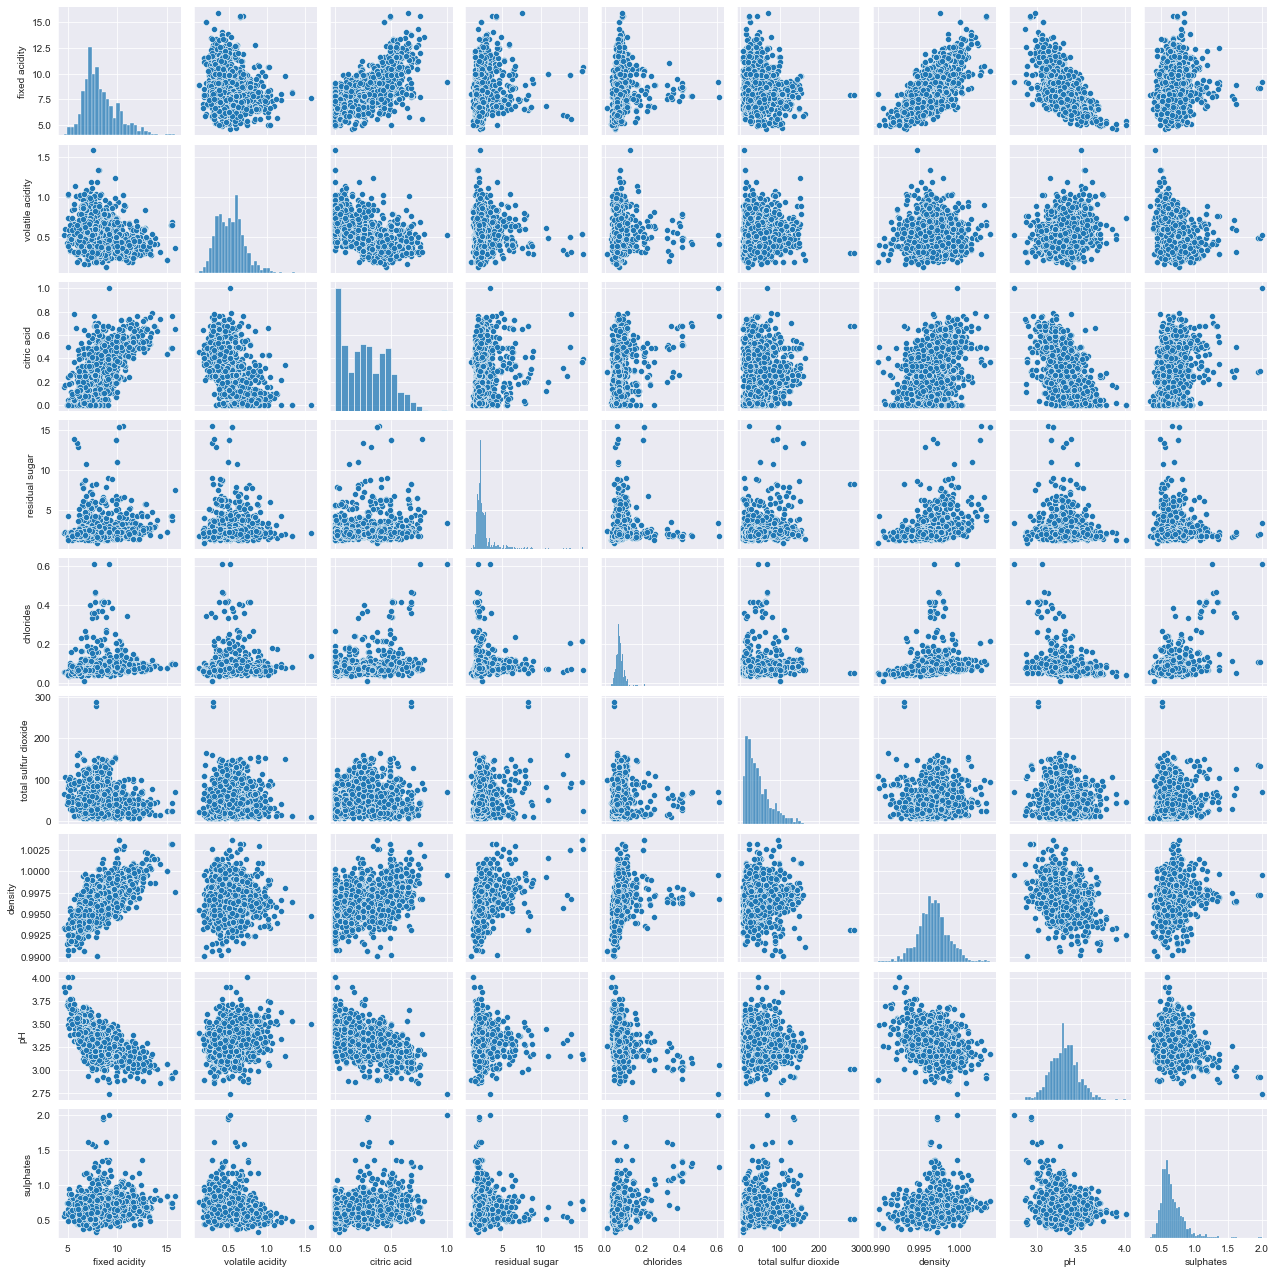

In [7]:
sns.pairplot(df, height=2)

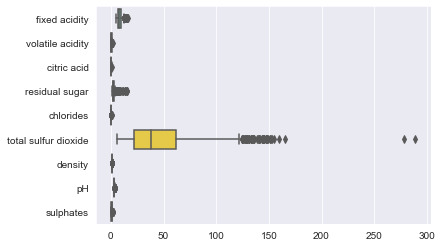

In [8]:
# Have a look at outliers
ax = sb.boxplot(data=df, orient="h", palette="Set2")

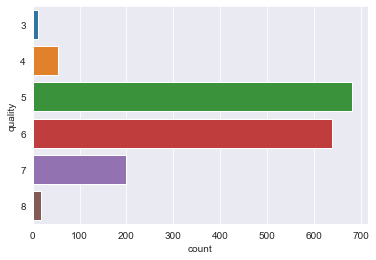

In [9]:
# Display countplot of categorical features
for col in df.select_dtypes(exclude='number'):
    if df[col].nunique() < 10:
        sns.countplot(y=col, data=df)
        plt.show()

As quality 3 and 8 are underrepresented, we may have to use sampling techniques

### Data cleaning and manipulation

In [10]:
X = df.drop(columns='quality').copy()
y = df.quality.copy()

In [11]:
# Use SMOTEENN to sampling classes
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=1)
X, y = sme.fit_resample(X, y)

In [12]:
# Retrive num_cols and cat_cols
num_cols = list(X._get_numeric_data().columns)
cat_cols = list(set(X.columns) - set(num_cols))

In [13]:
# StandardScale the dataset and convert it back to dataframe type
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_X = sc.fit_transform(X)
X = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)

### Split into train and test sets

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

##### Build XGB model paired with Optuna

In [15]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    
    param = {
        'tree_method':'gpu_hist',  # Use GPU acceleration
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        )}
    model = XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    return f1

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-11 00:21:00,161] A new study created in memory with name: no-name-56eb9117-da22-4440-99b7-f39ffceb5f2e
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:01,824] Trial 0 finished with value: 0.49076835451736456 and parameters: {'lambda': 0.0025568415310175245, 'alpha': 1.281233042073683, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 150, 'max_depth': 15, 'min_child_weight': 180}. Best is trial 0 with value: 0.49076835451736456.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:03,052] Trial 1 finished with value: 0.09733901915891739 and parameters: {'lambda': 0.021462241095834323, 'alpha': 0.02240165857155496, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 271}. Best is trial 0 with value: 0.49076835451736456.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:05,519] Trial 2 finished with value: 0.09733901915891739 and parameters: {'lambda': 0.1663451437305659, 'alpha': 0.4371299080238469, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 222}. Best is trial 0 with value: 0.49076835451736456.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:08,230] Trial 3 finished with value: 0.4930528011754104 and parameters: {'lambda': 0.40429985071257823, 'alpha': 0.06516271890964134, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 162}. Best is trial 3 with value: 0.4930528011754104.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:11,040] Trial 4 finished with value: 0.7649736223032744 and parameters: {'lambda': 0.0033639982892535495, 'alpha': 0.7224156910786858, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 45}. Best is trial 4 with value: 0.7649736223032744.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:15,364] Trial 5 finished with value: 0.859817538137227 and parameters: {'lambda': 0.0011200856321300298, 'alpha': 0.006139944848674459, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 14}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:16,848] Trial 6 finished with value: 0.5394308412135691 and parameters: {'lambda': 0.031454490412795584, 'alpha': 0.0031903397836984355, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 150, 'max_depth': 15, 'min_child_weight': 118}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:19,630] Trial 7 finished with value: 0.56568332182389 and parameters: {'lambda': 1.1807387957905242, 'alpha': 0.0019520181998049896, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 161}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:22,068] Trial 8 finished with value: 0.6959296742798552 and parameters: {'lambda': 0.06145858286667885, 'alpha': 0.4755894571676835, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 72}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:47,454] Trial 9 finished with value: 0.09733901915891739 and parameters: {'lambda': 2.5846214229017037, 'alpha': 0.22806133130263254, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 3000, 'max_depth': 17, 'min_child_weight': 241}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:50,745] Trial 10 finished with value: 0.8236094063268105 and parameters: {'lambda': 8.912019475284636, 'alpha': 7.052029494295116, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:21:55,348] Trial 11 finished with value: 0.8553572755949698 and parameters: {'lambda': 9.322516575916772, 'alpha': 9.374193758990213, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 5 with value: 0.859817538137227.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:00,018] Trial 12 finished with value: 0.9067039327084344 and parameters: {'lambda': 0.008912543885848277, 'alpha': 0.011257107731202401, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:02,304] Trial 13 finished with value: 0.6425592932622877 and parameters: {'lambda': 0.001146371182992848, 'alpha': 0.01587789018540858, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 86}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:05,192] Trial 14 finished with value: 0.8587032315976498 and parameters: {'lambda': 0.007717546050606679, 'alpha': 0.00562757885660986, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:31,135] Trial 15 finished with value: 0.8115831659194315 and parameters: {'lambda': 0.001054120892050852, 'alpha': 0.0010406954301682208, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 3000, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:33,167] Trial 16 finished with value: 0.5740033630463403 and parameters: {'lambda': 0.008822288072884286, 'alpha': 0.010070224646849793, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 102}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:36,026] Trial 17 finished with value: 0.7473149509538777 and parameters: {'lambda': 0.0033213490052811704, 'alpha': 0.05116391709112275, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 44}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:22:39,569] Trial 18 finished with value: 0.8914332582165997 and parameters: {'lambda': 0.0010384297666528606, 'alpha': 0.0011453720490679096, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:08,230] Trial 19 finished with value: 0.5005149695489319 and parameters: {'lambda': 0.01231618134229523, 'alpha': 0.0014640283503756307, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 131}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:10,541] Trial 20 finished with value: 0.6864316398346578 and parameters: {'lambda': 0.07279808959733428, 'alpha': 0.0037984868329436587, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 70}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:13,656] Trial 21 finished with value: 0.8341401368073709 and parameters: {'lambda': 0.001359506442261666, 'alpha': 0.00761996915031261, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 24}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:16,838] Trial 22 finished with value: 0.8604314835876195 and parameters: {'lambda': 0.0024159831791033333, 'alpha': 0.029247350611117957, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:20,177] Trial 23 finished with value: 0.8723077879646802 and parameters: {'lambda': 0.003466522790834434, 'alpha': 0.029924686008584375, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:22,740] Trial 24 finished with value: 0.768189293605665 and parameters: {'lambda': 0.005752483355363212, 'alpha': 0.17026100669151767, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 39}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:25,131] Trial 25 finished with value: 0.7072676342056511 and parameters: {'lambda': 0.021430830181594605, 'alpha': 0.05802385540034637, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 65}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:28,525] Trial 26 finished with value: 0.8634978490976001 and parameters: {'lambda': 0.004573176004114235, 'alpha': 0.020290774666883726, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:31,379] Trial 27 finished with value: 0.7987185436823783 and parameters: {'lambda': 0.012651015532619568, 'alpha': 0.0027286048696646805, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 5, 'min_child_weight': 32}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:32,566] Trial 28 finished with value: 0.09733901915891739 and parameters: {'lambda': 0.0021315705461582646, 'alpha': 0.121841846323067, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 298}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:23:35,124] Trial 29 finished with value: 0.46753153978799816 and parameters: {'lambda': 0.0024360689713724616, 'alpha': 0.01132921118198511, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 300, 'max_depth': 15, 'min_child_weight': 214}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:00,351] Trial 30 finished with value: 0.5979647276218399 and parameters: {'lambda': 0.0320094206281366, 'alpha': 0.034055128235088494, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 3000, 'max_depth': 13, 'min_child_weight': 96}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:03,279] Trial 31 finished with value: 0.7694771867598893 and parameters: {'lambda': 0.00544087886937053, 'alpha': 0.021118270946253095, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 26}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:05,774] Trial 32 finished with value: 0.7001926985394233 and parameters: {'lambda': 0.004318765245098515, 'alpha': 0.08422591829675398, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 61}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:08,343] Trial 33 finished with value: 0.8563091858551577 and parameters: {'lambda': 0.0017818930895586373, 'alpha': 0.014438575399914083, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 12 with value: 0.9067039327084344.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:13,523] Trial 34 finished with value: 0.9147272483559452 and parameters: {'lambda': 0.18373199546687657, 'alpha': 0.03379812707353177, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 8}. Best is trial 34 with value: 0.9147272483559452.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:16,102] Trial 35 finished with value: 0.7674187302884803 and parameters: {'lambda': 0.35834065663889536, 'alpha': 0.03816483132482771, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 54}. Best is trial 34 with value: 0.9147272483559452.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:25,882] Trial 36 finished with value: 0.9317758637729323 and parameters: {'lambda': 0.20460682137336034, 'alpha': 2.718694684694119, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 36 with value: 0.9317758637729323.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:30,377] Trial 37 finished with value: 0.8340166677986988 and parameters: {'lambda': 0.18783229554300698, 'alpha': 3.291403707317631, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 24}. Best is trial 36 with value: 0.9317758637729323.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:32,940] Trial 38 finished with value: 0.454409469349816 and parameters: {'lambda': 0.1460931123713934, 'alpha': 1.7554643879320952, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 201}. Best is trial 36 with value: 0.9317758637729323.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:35,862] Trial 39 finished with value: 0.6046083024309895 and parameters: {'lambda': 0.479648063992928, 'alpha': 0.2736421509913841, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 81}. Best is trial 36 with value: 0.9317758637729323.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:40,401] Trial 40 finished with value: 0.8382251914238293 and parameters: {'lambda': 0.826544651328616, 'alpha': 0.833293176235261, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 30}. Best is trial 36 with value: 0.9317758637729323.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:24:51,974] Trial 41 finished with value: 0.951771366720786 and parameters: {'lambda': 0.2700455507679958, 'alpha': 0.11282151726743463, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:01,276] Trial 42 finished with value: 0.913165698866447 and parameters: {'lambda': 0.2418973381194811, 'alpha': 4.248644477633843, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:06,081] Trial 43 finished with value: 0.8497352875593741 and parameters: {'lambda': 0.265670548577259, 'alpha': 4.757425429823984, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 19}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:09,941] Trial 44 finished with value: 0.7959990093564138 and parameters: {'lambda': 0.12483465999972679, 'alpha': 1.6582142799332418, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 40}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:14,977] Trial 45 finished with value: 0.8305055298983172 and parameters: {'lambda': 0.6943304256251466, 'alpha': 9.538518525307099, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 13}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:18,647] Trial 46 finished with value: 0.7760702017131489 and parameters: {'lambda': 2.045812162426733, 'alpha': 3.1708198594049906, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 54}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:21,278] Trial 47 finished with value: 0.09733901915891739 and parameters: {'lambda': 0.07386435659851917, 'alpha': 0.49317032020101553, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 17, 'min_child_weight': 257}. Best is trial 41 with value: 0.951771366720786.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:32,203] Trial 48 finished with value: 0.953646383744603 and parameters: {'lambda': 0.23488099889495107, 'alpha': 0.9450385774312273, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:34,843] Trial 49 finished with value: 0.49119214173270725 and parameters: {'lambda': 0.2799530403576187, 'alpha': 1.1931999781404188, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 178}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:44,016] Trial 50 finished with value: 0.9286237108711357 and parameters: {'lambda': 0.044917799952864115, 'alpha': 3.016558783812791, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:52,332] Trial 51 finished with value: 0.9337170132239543 and parameters: {'lambda': 0.04416303492325729, 'alpha': 2.6974872347743633, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:25:57,113] Trial 52 finished with value: 0.8561656884346588 and parameters: {'lambda': 0.042763997273645604, 'alpha': 2.2880144297061524, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 18}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:01,008] Trial 53 finished with value: 0.8086404452928386 and parameters: {'lambda': 0.10155114418393096, 'alpha': 1.316616105242672, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 35}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:05,812] Trial 54 finished with value: 0.8698322507439852 and parameters: {'lambda': 0.055626588513368394, 'alpha': 6.340598444427023, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:15,244] Trial 55 finished with value: 0.9516080644447984 and parameters: {'lambda': 0.18482714596702332, 'alpha': 0.8919532129180948, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:28,417] Trial 56 finished with value: 0.953626853349402 and parameters: {'lambda': 0.49849462954637574, 'alpha': 0.5735807117493057, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:31,207] Trial 57 finished with value: 0.5461831093437257 and parameters: {'lambda': 1.2804049885924038, 'alpha': 0.7299377161756203, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 142}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:35,552] Trial 58 finished with value: 0.8172450643062801 and parameters: {'lambda': 0.6190061907878138, 'alpha': 0.42566011254469405, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 20}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:39,703] Trial 59 finished with value: 0.7861373654127296 and parameters: {'lambda': 0.4219595139027398, 'alpha': 0.3143386003672743, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 42}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:43,832] Trial 60 finished with value: 0.8129519889896897 and parameters: {'lambda': 0.09571427686172215, 'alpha': 0.9363869695658504, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 15, 'min_child_weight': 29}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:52,270] Trial 61 finished with value: 0.9358725332942295 and parameters: {'lambda': 0.04130806162161684, 'alpha': 2.4852920056550225, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:26:58,663] Trial 62 finished with value: 0.9130916583306682 and parameters: {'lambda': 0.024766558311371225, 'alpha': 2.2691439619131053, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:27:02,158] Trial 63 finished with value: 0.7860764064355205 and parameters: {'lambda': 0.1111690138017125, 'alpha': 0.5259286807670563, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 50}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:27:11,430] Trial 64 finished with value: 0.9515843009940846 and parameters: {'lambda': 0.32692111240558597, 'alpha': 1.1386252917332567, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:27:16,320] Trial 65 finished with value: 0.8684329758134977 and parameters: {'lambda': 1.0401779363706725, 'alpha': 1.0908066278492803, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:27:18,688] Trial 66 finished with value: 0.7898939249870714 and parameters: {'lambda': 0.3007320343611742, 'alpha': 0.18513046207736158, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 33}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:27:24,587] Trial 67 finished with value: 0.9131044285666331 and parameters: {'lambda': 0.46029243287568794, 'alpha': 0.6317294616880438, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 48 with value: 0.953646383744603.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:27:59,627] Trial 68 finished with value: 0.967352513966736 and parameters: {'lambda': 0.08226536274621497, 'alpha': 1.6331579651776222, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 68 with value: 0.967352513966736.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:28:36,456] Trial 69 finished with value: 0.9329237284810105 and parameters: {'lambda': 0.16121229041237242, 'alpha': 1.724606862128393, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 22}. Best is trial 68 with value: 0.967352513966736.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:28:48,650] Trial 70 finished with value: 0.6165029954655226 and parameters: {'lambda': 1.6259524984779503, 'alpha': 0.40581685581951743, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 11, 'min_child_weight': 116}. Best is trial 68 with value: 0.967352513966736.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:29:31,976] Trial 71 finished with value: 0.9674523763941214 and parameters: {'lambda': 3.565585976247256, 'alpha': 1.4486881242008096, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:30:14,566] Trial 72 finished with value: 0.9457614301455796 and parameters: {'lambda': 4.796986887140525, 'alpha': 1.622973923417798, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 8}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:30:58,405] Trial 73 finished with value: 0.9459646583266939 and parameters: {'lambda': 4.878918824953733, 'alpha': 1.450561028337122, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:31:15,104] Trial 74 finished with value: 0.8935328209385838 and parameters: {'lambda': 4.055129564356576, 'alpha': 0.6704431572905152, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 27}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:31:50,797] Trial 75 finished with value: 0.9395246174477293 and parameters: {'lambda': 8.090266218425839, 'alpha': 1.0433218884422928, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 16}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:33:02,418] Trial 76 finished with value: 0.9649090057471854 and parameters: {'lambda': 3.6019516511344145, 'alpha': 1.4789067182302382, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:34:25,944] Trial 77 finished with value: 0.9652991784955569 and parameters: {'lambda': 2.7100908009769173, 'alpha': 0.11504440764094802, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:34:44,915] Trial 78 finished with value: 0.8546640064453992 and parameters: {'lambda': 3.188986828396218, 'alpha': 0.11543570800247058, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 37}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:35:17,818] Trial 79 finished with value: 0.9079496250653054 and parameters: {'lambda': 6.7865679127199305, 'alpha': 0.06641952727402896, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 24}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:35:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:35:41,396] Trial 80 finished with value: 0.28843814684210517 and parameters: {'lambda': 2.3405029811867344, 'alpha': 0.168772844879273, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 299}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:36:42,244] Trial 81 finished with value: 0.9594498496137753 and parameters: {'lambda': 0.349139162024171, 'alpha': 0.32481502553276365, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 3}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:36:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:37:15,031] Trial 82 finished with value: 0.9295799297897271 and parameters: {'lambda': 1.6748763791201293, 'alpha': 0.31383956802734153, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:38:33,867] Trial 83 finished with value: 0.9649938283646907 and parameters: {'lambda': 3.111099353174293, 'alpha': 0.20367240655707383, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:38:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:39:15,890] Trial 84 finished with value: 0.9475952710672858 and parameters: {'lambda': 3.8323961129471735, 'alpha': 0.22260628608899238, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 10}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:39:33,525] Trial 85 finished with value: 0.8084359653805117 and parameters: {'lambda': 2.8973922325461503, 'alpha': 0.0863718916822658, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 46}. Best is trial 71 with value: 0.9674523763941214.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:39:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:40:44,072] Trial 86 finished with value: 0.96749066547234 and parameters: {'lambda': 0.587325774694435, 'alpha': 0.1599652897209969, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 86 with value: 0.96749066547234.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:41:20,036] Trial 87 finished with value: 0.9209802830121895 and parameters: {'lambda': 6.144210069992031, 'alpha': 0.35646712791239665, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 22}. Best is trial 86 with value: 0.96749066547234.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:41:38,354] Trial 88 finished with value: 0.85624095003359 and parameters: {'lambda': 0.8471784590894985, 'alpha': 0.18366940274333152, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 31}. Best is trial 86 with value: 0.96749066547234.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:42:23,485] Trial 89 finished with value: 0.9548216148123947 and parameters: {'lambda': 0.5391432927544844, 'alpha': 0.25251647831316687, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 86 with value: 0.96749066547234.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:42:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:43:09,699] Trial 90 finished with value: 0.9505940257822371 and parameters: {'lambda': 1.3292003546206799, 'alpha': 0.2523366042645401, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 8}. Best is trial 86 with value: 0.96749066547234.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-11 00:44:04,854] Trial 91 finished with value: 0.9593170109037475 and parameters: {'lambda': 0.5903361926466827, 'alpha': 0.5617333697516855, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 5}. Best is trial 86 with value: 0.96749066547234.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
# save results
df_results = study.trials_dataframe()
df_results.to_pickle('./df_optuna_results.pkl')
df_results.to_csv('./df_optuna_results.csv')

In [ ]:
df_results

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# plot feature importance for algorithm parameters
optuna.visualization.plot_param_importances(study)

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [ ]:
# Build model with the best params
best = XGBClassifier(**study.best_params )
best.fit(X_train, y_train)

In [ ]:
y_pred = best.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = pd.DataFrame(y_pred, columns=['Quality'], index=df_test.index)
# saving the dataframe 
y_pred.to_csv('Predictions.csv') 

In [ ]:
study.trials_dataframe().head()